<a href="https://colab.research.google.com/github/scottspurlock/csc4466-s2024/blob/main/demos/day17_tutorial_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Day 17 Tutorial - Convolutional Neural Networks with Tensorflow


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Get the data

In [2]:
# flowers: 'https://drive.google.com/uc?export=download&id=1clO8535JBBW2Ye1V6KVpDQJk2Baioq8_'

# Download and unzip flowers.zip file.
# Should create 3 folders.
# https://drive.google.com/file/d/1clO8535JBBW2Ye1V6KVpDQJk2Baioq8_/view?usp=drive_link
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1clO8535JBBW2Ye1V6KVpDQJk2Baioq8_',
                                    dest_path='/content/flowers.zip',
                                    unzip=True)

## Visualize an example image

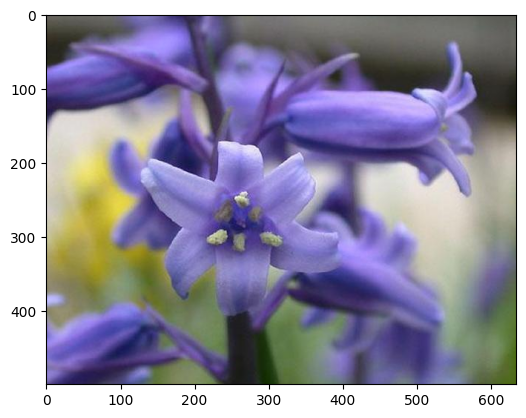

In [3]:
bgr = cv2.imread('flowers/bluebell/image_0241.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

# Set some parameters
We'll process images in batches of 32 at a time, and we'll resize each image to 180 x 180.

In [4]:
batch_size = 12
img_height = 180
img_width = 180


In [5]:
# This is the folder where our images are
data_dir = 'flowers'

# Tensorflow will choose some of the images as training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 240 files belonging to 3 classes.
Using 180 files for training.


In [6]:
# Tensorflow will chooose the rest of the images as validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 240 files belonging to 3 classes.
Using 60 files for validation.


In [7]:
# The class names (the names of the different types of images) are
# automatically inferred from the folder names.
class_names = train_ds.class_names
print(class_names)


['bluebell', 'daisy', 'sunflower']


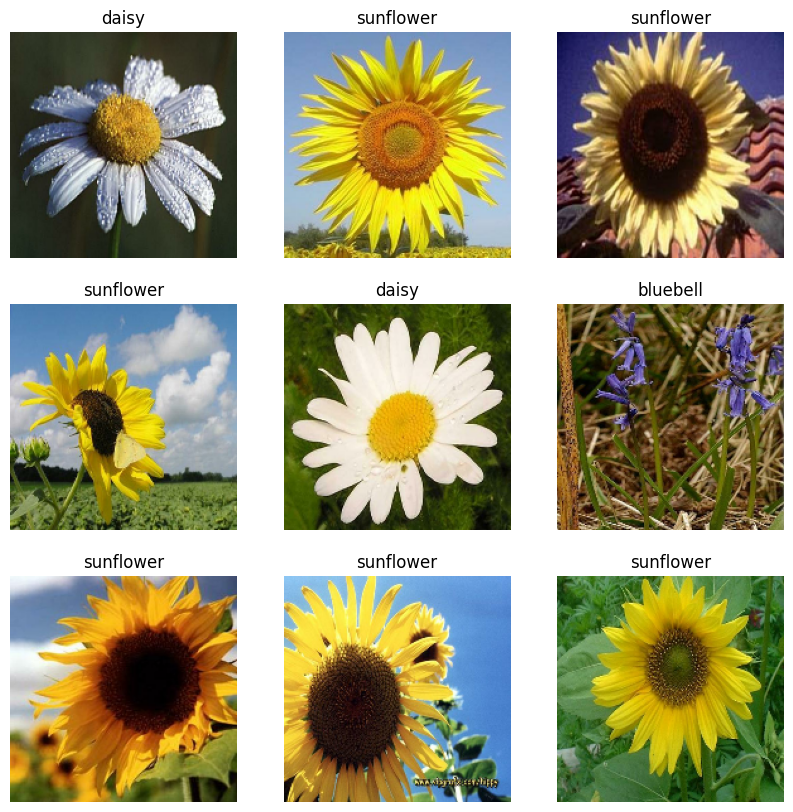

In [8]:
# The Tensorflow train_ds object makes it easy to get to the images and
# visualize them
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Set a few values to make performance better for loading images

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Create the neural network (model)

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])


In [11]:
# Compiling the model gets it ready to train.
# We tell it which optimizer to use to find the best weights (Adam),
# What the learning rate is (how big a step to take while optimizing),
# and what loss function to use, and what metrics to keep track of (accuracy).
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
# Print out a summary of the layers of the model.
# Note that the number of parameters learned for convolution is much smaller than
# for dense (fully connected) layers, so CNN trains faster.
# Number of parameters learned is (h x w x d + 1) x k = (3 x 3 x 3 + 1) x 16 = 448
# (where the +1 is for the bias term)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense (Dense)               (None, 32)                4147232   
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

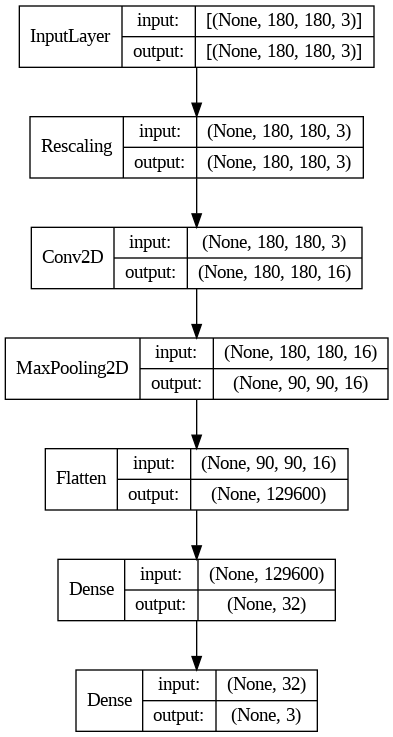

In [13]:
# Visualize the layers of the model.
# (None, 180, 180, 3) means that the model can handle various numbers of images,
# but they all have to be 180x180 and have 3 color channels.
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

## Train (fit) the model
An epoch is one iteration of training, where the model sees each training example one time.

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
15/15 [==============================] - 3s 27ms/step - loss: 0.7796 - accuracy: 0.6778 - val_loss: 0.4169 - val_accuracy: 0.8833
Epoch 2/10
15/15 [==============================] - 0s 9ms/step - loss: 0.2845 - accuracy: 0.9056 - val_loss: 0.1544 - val_accuracy: 0.9833
Epoch 3/10
15/15 [==============================] - 0s 9ms/step - loss: 0.1526 - accuracy: 0.9500 - val_loss: 0.1163 - val_accuracy: 0.9833
Epoch 4/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0958 - accuracy: 0.9833 - val_loss: 0.1024 - val_accuracy: 0.9833
Epoch 5/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0740 - accuracy: 0.9889 - val_loss: 0.0723 - val_accuracy: 0.9833
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 0.9833
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.9944 - val_loss: 0.0635 - val_accuracy: 0.9833
Epoch 8/10
15/15 [=

## Visualize the results

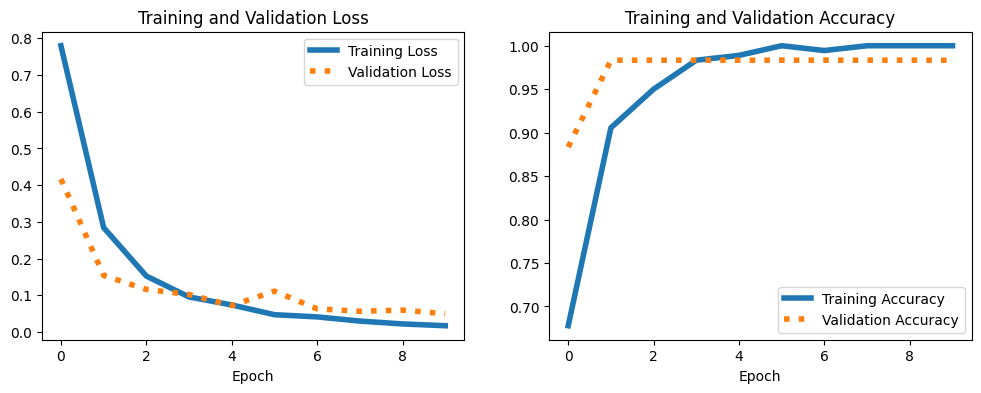

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, '-', label='Training Loss', linewidth=4)
plt.plot(epochs_range, val_loss, ':', label='Validation Loss', linewidth=4)
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, '-', label='Training Accuracy', linewidth=4)
plt.plot(epochs_range, val_acc, ':', label='Validation Accuracy', linewidth=4)
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

## Download a new image and predict it with the trained model.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1284k  100 1284k    0     0  4712k      0 --:--:-- --:--:-- --:--:-- 4723k


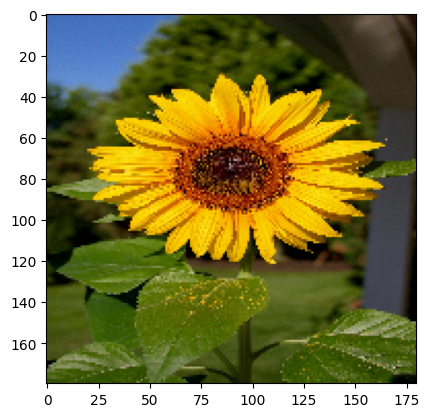

1/1 [==============================] - 0s 121ms/step
Predictions:
[[-4.129273  -2.564682   5.3966775]]
Probabilities:
tf.Tensor([7.2903640e-05 3.4853182e-04 9.9957854e-01], shape=(3,), dtype=float32)
This image most likely belongs to sunflower with a 99.96 percent confidence.


In [16]:
url = 'https://images.unsplash.com/photo-1566669086984-077347c1f4bb?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=679&q=80'

!curl -o download.png {url}
img = cv2.imread('download.png')
img = cv2.resize(img, (img_width, img_height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Reshape it so that it is 1 x h x w x 3
# (The first 1 puts the image in a batch of size 1)
img_array = np.reshape(img, (1, img_height, img_width, 3))

# Predict the image with the model
predictions = model.predict(img_array)
print('Predictions:')
print(predictions)

# Use softmax to convert the scores coming out of the neural network
# into probabilities (sum to 1)
score = tf.nn.softmax(predictions[0])
print('Probabilities:')
print(score)

# Figure out which class is predicted based on the highest probability
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


## Visualizing model weights

In [17]:
model.layers

## Pull out the learned weights for the convolution layer
There should be 16 3x3x3 kernels (filters)

In [18]:
cnn_layer1 = model.layers[1]
weights = cnn_layer1.get_weights()
weights[0].shape

(3, 3, 3, 16)

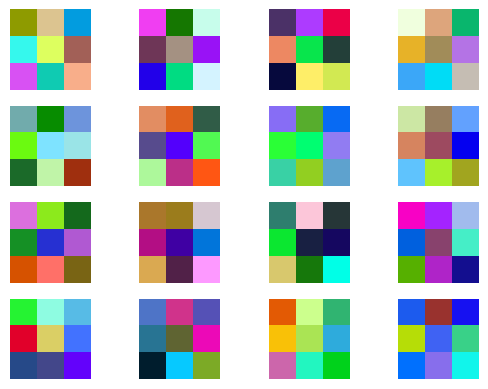

In [19]:
# We can visualize each 3x3x3 kernel as an image
for i in range(16):
    plt.subplot(4, 4, i+1)
    kernel = weights[0][:, :, :, i]
    normalized = cv2.normalize(kernel,  None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    plt.imshow(normalized)
    plt.axis('off')

## Visualize the response
When an input image is passed into the convolution layer, the model performs convolution with each of the 16 kernels.

We can visualize the 16 outputs (responses) by making a short model that stops after the convolution.

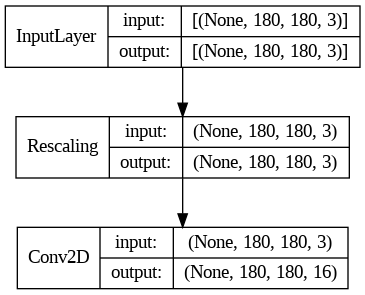

In [20]:
# The short model has the same inputs as the original model, but outputs after
# the convolution layer (index 1).
model_short = tf.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)
tf.keras.utils.plot_model(model_short, show_shapes=True, show_layer_names=False)

In [21]:
# Reshape it so that it is 1 x h x w x 3
# (The first 1 puts the image in a batch of size 1)
img = cv2.resize(img, (img_width, img_height))
img_array = np.reshape(img, (1, img_height, img_width, 3))

# Predict the image with the model
predictions = model_short.predict(img_array)
predictions.shape

1/1 [==============================] - 0s 95ms/step


(1, 180, 180, 16)

Visualize the 16 responses to the kernels learned for the convolution layer.

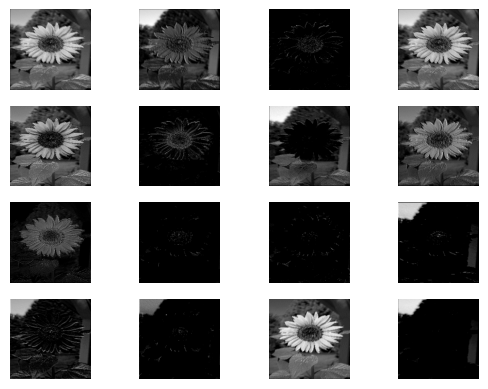

In [22]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    response = predictions[0, :, :, i]
    normalized = cv2.normalize(response,  None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    plt.imshow(normalized, cmap='gray')
    plt.axis('off')
